# Problem description

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.

Perhaps you are contemplating lending money to a company, and need to know whether the company
is in near-term danger of not being able to repay.


## Goal

## Learning objectives

- Demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.
- We will make suggestions for ways to approach the problem
    - But there will be little explicit direction for this task.
- It is meant to be analogous to a pre-interview task that a potential employer might assign
to verify your skill

# Import modules

In [17]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline


# API for students

In [18]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [19]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

In [20]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


Pretty *unhelpful* !

What are these mysteriously named features ?

## Description of attributes

This may still be somewhat unhelpful for those of you not used to reading Financial Statements.

But that's partially the point of the exercise
- You can *still* perform Machine Learning *even if* you are not an expert in the problem domain
    - That's what makes this a good interview exercise: you can demonstrate your thought process even if you don't know the exact meaning of the terms
- Of course: becoming an expert in the domain *will improve* your ability to create better models
    - Feature engineering is easier if you understand the features, their inter-relationships, and the relationship to the target

Let's get a feel for the data
- What is the type of each attribute ?


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

You may be puzzled:
- Most attributes are `object` and *not* numeric (`float64`)
- But looking at the data via `data.head()` certainly gives the impression that all attributes are numeric

Welcome to the world of messy data !  The dataset has represented numbers as strings.
- These little unexpected challenges are common in the real-word
- Data is rarely perfect and clean

So you might want to first convert all attributes to numeric

**Hint**
- Look up the Pandas method `to_numeric`
    - We suggest you use the option `errors='coerce'`
    

# Evaluating your project

We will evaluate your submission on a test dataset that we provide
- It has no labels, so **you** can't use it to evaluate your model, but **we** have the labels
- We will call this evaluation dataset the "holdout" data

Let's get it

In [22]:
holdout_data = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

print("Data shape: ", holdout_data.shape)


Data shape:  (1092, 65)


We will evaluate your model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of your submission will be partially based on how you made (and described) the trade-off.

You may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

# Your model

Time for you to continue the Recipe for Machine Learning on your own.



# ----------------------------------------------Start-----------------------------------

In [23]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

# Recipe step A: Get the data

## Recipe A.1: Get the data

In [24]:
df = data

## Recipe A.2: Have a look at data

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

In [26]:
def to_numeric(df):
    columns = df.select_dtypes(include=['object']).columns
    df[columns] = df[columns].apply(pd.to_numeric, errors='coerce')
    return df
df= to_numeric(df)
df.describe()
df.info()
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
count,4816.000000,4816.000000,4816.000000,4803.000000,4.808000e+03,4816.000000,4816.000000,4804.000000,4818.000000,4816.000000,...,4816.000000,4818.000000,4816.000000,4.598000e+03,4806.000000,4818.000000,4803.000000,4735.000000,4818.000000,4818.000000
mean,-0.055232,0.533272,0.188992,4.978602,1.956441e+01,-0.070060,-0.042516,5.739985,1.579277,0.503606,...,0.022793,0.959585,0.273025,1.108795e+03,11.021303,177.494445,9.287631,38.557533,0.063927,3499.858032
std,6.707351,1.202909,1.282430,100.273952,2.384491e+04,7.778523,6.707970,109.508001,1.342723,4.044036,...,7.249022,0.932427,6.338601,7.106563e+04,43.821146,2279.713700,113.225922,588.711967,0.244648,1392.049260
min,-463.890000,0.000000,-72.067000,0.000000,-1.076400e+06,-463.890000,-463.890000,-3.735100,0.000191,-71.444000,...,-468.670000,-0.085920,-184.980000,-1.244000e+01,-0.092493,0.000000,0.000000,-3.726500,0.000000,1071.000000
25%,0.004047,0.254670,0.044923,1.099200,-4.312000e+01,0.000000,0.005985,0.481588,1.015600,0.318990,...,0.015574,0.876940,0.000000,5.298300e+00,4.229925,45.065750,3.074350,2.114850,0.000000,2296.250000
50%,0.046487,0.451495,0.218560,1.642300,3.673450e-01,0.000000,0.056685,1.149000,1.140500,0.522325,...,0.108940,0.950825,0.006320,9.038900e+00,6.176800,73.879500,4.928700,4.077200,0.000000,3500.500000
75%,0.116730,0.662177,0.420152,2.929200,4.986775e+01,0.110470,0.136025,2.781300,1.814050,0.721823,...,0.240262,0.990358,0.206915,1.720750e+01,9.302800,118.597500,8.067850,9.187600,0.000000,4704.750000
max,2.352300,72.416000,28.336000,6845.800000,1.250100e+06,203.150000,2.352300,6868.500000,37.807000,266.860000,...,87.981000,47.788000,308.150000,4.818700e+06,1308.500000,127450.000000,7641.300000,28999.000000,1.000000,5909.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4816 non-null   float64
 1   X2        4816 non-null   float64
 2   X3        4816 non-null   float64
 3   X4        4803 non-null   float64
 4   X5        4808 non-null   float64
 5   X6        4816 non-null   float64
 6   X7        4816 non-null   float64
 7   X8        4804 non-null   float64
 8   X9        4818 non-null   float64
 9   X10       4816 non-null   float64
 10  X11       4816 non-null   float64
 11  X12       4803 non-null   float64
 12  X13       4818 non-null   float64
 13  X14       4816 non-null   float64
 14  X15       4812 non-null   float64
 15  X16       4804 non-null   float64
 16  X17       4804 non-null   float64
 17  X18       4816 non-null   float64
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4744 non-null   floa

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.417690,0.05680,1.1605,-126.390,0.413550,0.025417,1.23950,1.16500,0.51773,...,0.049094,0.85835,0.123220,5.6167,7.4042,164.310,2.2214,1.3340,0,4510
1,-0.023834,0.210100,0.50839,4.2374,22.034,0.058412,-0.027621,3.65790,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.8020,6.4782,0,3537
2,0.030515,0.446060,0.19569,1.5650,35.766,0.281960,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.252660,15.0490,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.6800,438.200,0.136490,0.058164,10.85300,1.02790,0.61173,...,0.085524,0.97282,0.000000,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.497120,0.12316,1.3036,-71.398,0.000000,0.001007,1.01160,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.5820,114.580,3.1854,2.7420,0,1529


In [27]:
X = df.iloc[:,0:64]
y = df.iloc[:,[64]]
a= X.isnull().sum().sum()
b = y.isnull().sum().sum()
print("There are {a1} null values in feature matrix and {a2} null values in target matrix".format(a1=a,a2=b))

There are 3742 null values in feature matrix and 0 null values in target matrix


**result**
- First, there are some numerical features in the form of object,therefore I turn the object features into numeric features.
- Second, By the isnull() function, I observe that feature matrix includes 3742 missing values,which should be addressed in the subsequent process. **feature X37 lacks of a lot of values. I prefer to delete this feature.**
- Third, the difference between maximum and minimum is larger than usual value, which means that the data is non-homogeneous or there are outliers in some features. 

# Recipe step B: Exploatory Data Analysis

## Recipe B1: Date imbalanced

array([[<Axes: title={'center': 'Bankrupt'}>]], dtype=object)

The number of survival is 4510 and of bankruptcy is 308


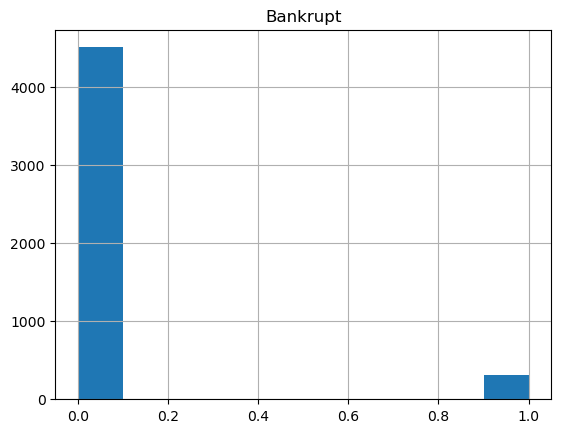

In [13]:
y.hist()
aa = y.loc[y.iloc[:,0]==0].size
bb = y.loc[y.iloc[:,0]==1].size
print("The number of survival is {a1} and of bankruptcy is {a2}".format(a1=aa,a2=bb))

## Recipe B2: Correlation Matrix

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix (Abs > 0.7)')

Text(0.5, 36.72222222222221, 'Variables')

Text(70.72222222222221, 0.5, 'Variables')

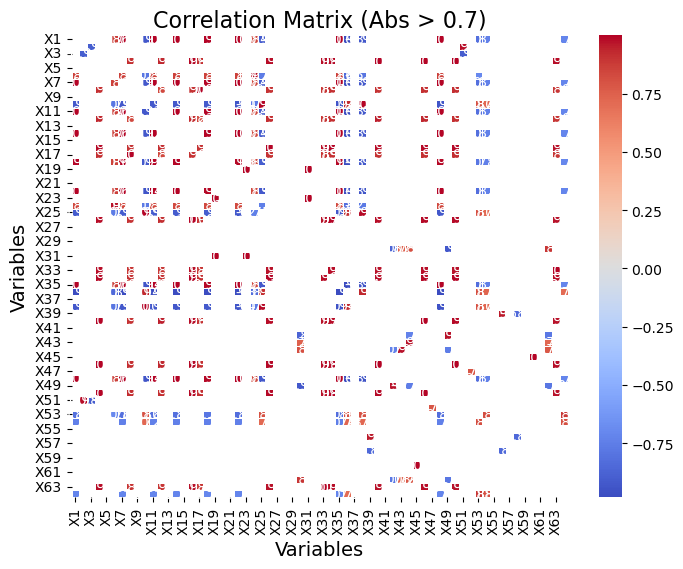

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = X.corr()

threshold = 0.7
filtered_corr_matrix = correlation_matrix[(correlation_matrix.abs() > threshold) & (correlation_matrix != 1.0)]

plt.figure(figsize=(8, 6))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix (Abs > 0.7)', fontsize=16)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Variables', fontsize=14)
plt.show()

## Recipe B3: Outliers

## Box plot

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada5e3b90>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada6d3450>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada543b50>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada6e8b90>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada6e9610>],
 'means': []}

Text(0.5, 1.0, 'feature 1')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada6f6a50>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada6fc710>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada6f40d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada6fd890>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada6fdf50>],
 'means': []}

Text(0.5, 1.0, 'feature 2')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada70c5d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada70d410>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada6ffe90>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada70e590>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada70ec50>],
 'means': []}

Text(0.5, 1.0, 'feature 3')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada711410>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada712290>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada710290>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada713390>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada713b50>],
 'means': []}

Text(0.5, 1.0, 'feature 4')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada7261d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada726fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada725c10>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada727fd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada730850>],
 'means': []}

Text(0.5, 1.0, 'feature 5')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada732d90>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada733c50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada732310>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada73cd10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada7130d0>],
 'means': []}

Text(0.5, 1.0, 'feature 6')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada73fa90>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada744990>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada73f410>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada745a10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada744890>],
 'means': []}

Text(0.5, 1.0, 'feature 7')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada754a50>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada7558d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada754310>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada756890>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada755750>],
 'means': []}

Text(0.5, 1.0, 'feature 8')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada761810>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada7626d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada761010>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada763310>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada6fc190>],
 'means': []}

Text(0.5, 1.0, 'feature 9')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada76e350>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada76f210>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada76dcd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada77c290>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada76ea50>],
 'means': []}

Text(0.5, 1.0, 'feature 10')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada77f210>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada7801d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada77eb90>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada781350>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada781a10>],
 'means': []}

Text(0.5, 1.0, 'feature 11')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada783f50>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada794e90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada783310>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada795ed0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada794d50>],
 'means': []}

Text(0.5, 1.0, 'feature 12')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada7a0c10>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada7a1bd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada797010>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada7a2bd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada7a1a10>],
 'means': []}

Text(0.5, 1.0, 'feature 13')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada7a9a10>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada7aa910>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada7a8750>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada7ab950>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada7a1350>],
 'means': []}

Text(0.5, 1.0, 'feature 14')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada7b6a10>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada7b7990>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada7b6310>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada7c4b10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada7c5210>],
 'means': []}

Text(0.5, 1.0, 'feature 15')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada7c7790>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada7d8810>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada7c67d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada7d9990>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada7d9e90>],
 'means': []}

Text(0.5, 1.0, 'feature 16')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada7e0750>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada7e1790>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada7db210>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada7e2850>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada7468d0>],
 'means': []}

Text(0.5, 1.0, 'feature 17')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada7f1950>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada7f2790>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada7f1250>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada7f3990>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada7b7510>],
 'means': []}

Text(0.5, 1.0, 'feature 18')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada7f6810>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada7f76d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada7f5990>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada8087d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada7d9010>],
 'means': []}

Text(0.5, 1.0, 'feature 19')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada80b250>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada814150>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada809c10>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada815250>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada6fec90>],
 'means': []}

Text(0.5, 1.0, 'feature 20')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada817e50>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada820d50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada816810>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada821ed0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada822750>],
 'means': []}

Text(0.5, 1.0, 'feature 21')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada82cdd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada82dd10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada82cad0>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada82eb50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dad79df450>],
 'means': []}

Text(0.5, 1.0, 'feature 22')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada83d8d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada83e850>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada83c310>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada83f890>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada7b7050>],
 'means': []}

Text(0.5, 1.0, 'feature 23')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada8464d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada847410>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada844f90>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada854410>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada854bd0>],
 'means': []}

Text(0.5, 1.0, 'feature 24')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada857110>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada860150>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada855ad0>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada861310>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada861ad0>],
 'means': []}

Text(0.5, 1.0, 'feature 25')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada863cd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada870c90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada862610>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada871d50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada870b10>],
 'means': []}

Text(0.5, 1.0, 'feature 26')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada878910>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada8798d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada854a90>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada87a9d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada87b090>],
 'means': []}

Text(0.5, 1.0, 'feature 27')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada885550>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada886290>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada873050>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada8872d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada887b50>],
 'means': []}

Text(0.5, 1.0, 'feature 28')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada871cd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada89afd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada8990d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada8a0150>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada863e50>],
 'means': []}

Text(0.5, 1.0, 'feature 29')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada8a1cd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada8a3c90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada8a2410>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada8b4c10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada8b5410>],
 'means': []}

Text(0.5, 1.0, 'feature 30')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada8b7a50>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada8b0990>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada8b7150>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada8b1a90>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada8b07d0>],
 'means': []}

Text(0.5, 1.0, 'feature 31')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada8cc550>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada8cd3d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada8b3510>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada8ce510>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada8cd350>],
 'means': []}

Text(0.5, 1.0, 'feature 32')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada8d5050>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada8d6010>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada8cfdd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada8d7010>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada8b7910>],
 'means': []}

Text(0.5, 1.0, 'feature 33')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada8e5f10>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada8e6e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada8e5610>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada8e7ed0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada5d6350>],
 'means': []}

Text(0.5, 1.0, 'feature 34')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada8fa9d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada8fb8d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada8f9410>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada900b10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada7f3850>],
 'means': []}

Text(0.5, 1.0, 'feature 35')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada903750>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada910710>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada9024d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada911790>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada911710>],
 'means': []}

Text(0.5, 1.0, 'feature 36')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada914210>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada915110>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada912dd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada916150>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada6fe950>],
 'means': []}

Text(0.5, 1.0, 'feature 37')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada924c90>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada925b90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada917890>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada926c50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada9272d0>],
 'means': []}

Text(0.5, 1.0, 'feature 38')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada935950>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada936790>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada934410>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada9378d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada900a50>],
 'means': []}

Text(0.5, 1.0, 'feature 39')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada93e350>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada93f190>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada93cd90>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada948250>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada948a90>],
 'means': []}

Text(0.5, 1.0, 'feature 40')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada94ad50>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada94b350>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada949750>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada960d10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada821550>],
 'means': []}

Text(0.5, 1.0, 'feature 41')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada963950>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada964810>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada962590>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada965850>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada80b890>],
 'means': []}

Text(0.5, 1.0, 'feature 42')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada9681d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada968f90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada966cd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada969f10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada968f10>],
 'means': []}

Text(0.5, 1.0, 'feature 43')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada980c10>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada981b10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada96bb50>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada982b10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada9819d0>],
 'means': []}

Text(0.5, 1.0, 'feature 44')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada991650>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada9924d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada967f90>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada993550>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada991e50>],
 'means': []}

Text(0.5, 1.0, 'feature 45')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada9a6250>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada9a7110>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada9a4f10>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada9a81d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada9a69d0>],
 'means': []}

Text(0.5, 1.0, 'feature 46')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada9aab10>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada9ab9d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada9a95d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada9b0910>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada9ab8d0>],
 'means': []}

Text(0.5, 1.0, 'feature 47')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada9b3510>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada9b8290>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada9b1fd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada9b9490>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada991c50>],
 'means': []}

Text(0.5, 1.0, 'feature 48')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada9d4050>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada9d4e50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada9bad50>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada9d5ed0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada9d4e10>],
 'means': []}

Text(0.5, 1.0, 'feature 49')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada9e0950>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada9e1810>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada9d7410>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada9e2890>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada9e1710>],
 'means': []}

Text(0.5, 1.0, 'feature 50')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dada9ed2d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1dada9ee210>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dada9e3dd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1dada9ef290>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada9ed290>],
 'means': []}

Text(0.5, 1.0, 'feature 51')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dadaa01d10>,
 'caps': [<matplotlib.lines.Line2D at 0x1dadaa02b10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dadaa00890>],
 'medians': [<matplotlib.lines.Line2D at 0x1dadaa03b10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada9b8650>],
 'means': []}

Text(0.5, 1.0, 'feature 52')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dadaa0e750>,
 'caps': [<matplotlib.lines.Line2D at 0x1dadaa0f4d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dadaa0d450>],
 'medians': [<matplotlib.lines.Line2D at 0x1dadaa20510>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada8cf510>],
 'means': []}

Text(0.5, 1.0, 'feature 53')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dadaa21590>,
 'caps': [<matplotlib.lines.Line2D at 0x1dadaa23d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dadaa21a90>],
 'medians': [<matplotlib.lines.Line2D at 0x1dadaa28f10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada8cf7d0>],
 'means': []}

Text(0.5, 1.0, 'feature 54')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dadaa2b910>,
 'caps': [<matplotlib.lines.Line2D at 0x1dadaa2c9d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dadaa2a850>],
 'medians': [<matplotlib.lines.Line2D at 0x1dadaa2da10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dad78f5650>],
 'means': []}

Text(0.5, 1.0, 'feature 55')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dadaa3c310>,
 'caps': [<matplotlib.lines.Line2D at 0x1dadaa3d210>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dadaa2ed10>],
 'medians': [<matplotlib.lines.Line2D at 0x1dadaa3e310>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada8e4310>],
 'means': []}

Text(0.5, 1.0, 'feature 56')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dadaa4ce90>,
 'caps': [<matplotlib.lines.Line2D at 0x1dadaa4dcd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dadaa3fc10>],
 'medians': [<matplotlib.lines.Line2D at 0x1dadaa4ed50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada82f550>],
 'means': []}

Text(0.5, 1.0, 'feature 57')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dadaa559d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1dadaa56890>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dadaa54710>],
 'medians': [<matplotlib.lines.Line2D at 0x1dadaa578d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dadaa3ef10>],
 'means': []}

Text(0.5, 1.0, 'feature 58')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dadaa66290>,
 'caps': [<matplotlib.lines.Line2D at 0x1dadaa67090>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dadaa64c50>],
 'medians': [<matplotlib.lines.Line2D at 0x1dadaa740d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dadaa55990>],
 'means': []}

Text(0.5, 1.0, 'feature 59')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dadaa76cd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1dadaa77ad0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dadaa758d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1dadaa84c10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada7c5850>],
 'means': []}

Text(0.5, 1.0, 'feature 60')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dadaa87690>,
 'caps': [<matplotlib.lines.Line2D at 0x1dadaa90510>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dadaa86090>],
 'medians': [<matplotlib.lines.Line2D at 0x1dadaa914d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dadaa90490>],
 'means': []}

Text(0.5, 1.0, 'feature 61')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dadaa93f10>,
 'caps': [<matplotlib.lines.Line2D at 0x1dadaaa0e90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dadaa92990>],
 'medians': [<matplotlib.lines.Line2D at 0x1dadaaa1f50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada900810>],
 'means': []}

Text(0.5, 1.0, 'feature 62')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dadaaa8ad0>,
 'caps': [<matplotlib.lines.Line2D at 0x1dadaaa9850>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dadaaa3dd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1dadaaaa810>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dada7f1890>],
 'means': []}

Text(0.5, 1.0, 'feature 63')

D:\temp\ipykernel_10956\352486669.py:16: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


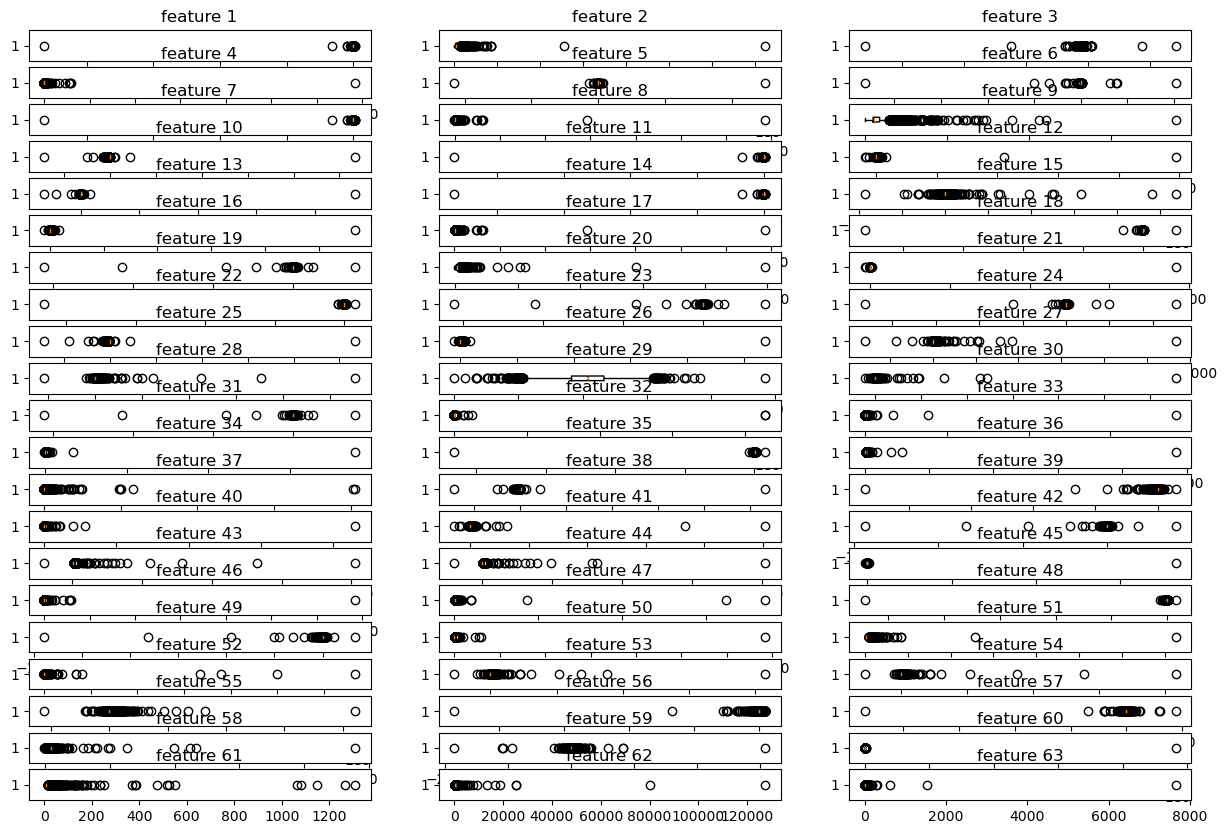

In [15]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(21, 3, figsize=(15, 10))
for i, ax in enumerate(axs.flat):
    xx = np.array(X.iloc[:,i]).astype(float)
    median = np.nanmedian(xx)
    xx[np.isnan(xx)] = median
    ax.boxplot(xx, vert=False,notch=True)
    ax.set_title(f'feature {i+1}')
    q1 = np.nanpercentile(xx, 25)
    q3 = np.nanpercentile(xx, 75)
    iqr = q3 - q1
    lower_threshold = q1 - 1.5 * iqr
    upper_threshold = q3 + 1.5 * iqr
    #outliers = xx[(xx < lower_threshold) | (xx > upper_threshold)]
    #plt.scatter(outliers, np.ones_like(outliers), color='red', label='Outliers')
plt.tight_layout()
plt.show()

## Recipe B4: heterogeneous data and the relationship between target and feature

## scatter diagram ( show the relationship between target and feature)

Text(0.5, 1.0, 'feature 1')

Text(0.5, 1.0, 'feature 2')

Text(0.5, 1.0, 'feature 3')

Text(0.5, 1.0, 'feature 4')

Text(0.5, 1.0, 'feature 5')

Text(0.5, 1.0, 'feature 6')

Text(0.5, 1.0, 'feature 7')

Text(0.5, 1.0, 'feature 8')

Text(0.5, 1.0, 'feature 9')

Text(0.5, 1.0, 'feature 10')

Text(0.5, 1.0, 'feature 11')

Text(0.5, 1.0, 'feature 12')

Text(0.5, 1.0, 'feature 13')

Text(0.5, 1.0, 'feature 14')

Text(0.5, 1.0, 'feature 15')

Text(0.5, 1.0, 'feature 16')

Text(0.5, 1.0, 'feature 17')

Text(0.5, 1.0, 'feature 18')

Text(0.5, 1.0, 'feature 19')

Text(0.5, 1.0, 'feature 20')

Text(0.5, 1.0, 'feature 21')

Text(0.5, 1.0, 'feature 22')

Text(0.5, 1.0, 'feature 23')

Text(0.5, 1.0, 'feature 24')

Text(0.5, 1.0, 'feature 25')

Text(0.5, 1.0, 'feature 26')

Text(0.5, 1.0, 'feature 27')

Text(0.5, 1.0, 'feature 28')

Text(0.5, 1.0, 'feature 29')

Text(0.5, 1.0, 'feature 30')

Text(0.5, 1.0, 'feature 31')

Text(0.5, 1.0, 'feature 32')

Text(0.5, 1.0, 'feature 33')

Text(0.5, 1.0, 'feature 34')

Text(0.5, 1.0, 'feature 35')

Text(0.5, 1.0, 'feature 36')

Text(0.5, 1.0, 'feature 37')

Text(0.5, 1.0, 'feature 38')

Text(0.5, 1.0, 'feature 39')

Text(0.5, 1.0, 'feature 40')

Text(0.5, 1.0, 'feature 41')

Text(0.5, 1.0, 'feature 42')

Text(0.5, 1.0, 'feature 43')

Text(0.5, 1.0, 'feature 44')

Text(0.5, 1.0, 'feature 45')

Text(0.5, 1.0, 'feature 46')

Text(0.5, 1.0, 'feature 47')

Text(0.5, 1.0, 'feature 48')

Text(0.5, 1.0, 'feature 49')

Text(0.5, 1.0, 'feature 50')

Text(0.5, 1.0, 'feature 51')

Text(0.5, 1.0, 'feature 52')

Text(0.5, 1.0, 'feature 53')

Text(0.5, 1.0, 'feature 54')

Text(0.5, 1.0, 'feature 55')

Text(0.5, 1.0, 'feature 56')

Text(0.5, 1.0, 'feature 57')

Text(0.5, 1.0, 'feature 58')

Text(0.5, 1.0, 'feature 59')

Text(0.5, 1.0, 'feature 60')

Text(0.5, 1.0, 'feature 61')

Text(0.5, 1.0, 'feature 62')

Text(0.5, 1.0, 'feature 63')

D:\temp\ipykernel_10956\428627102.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


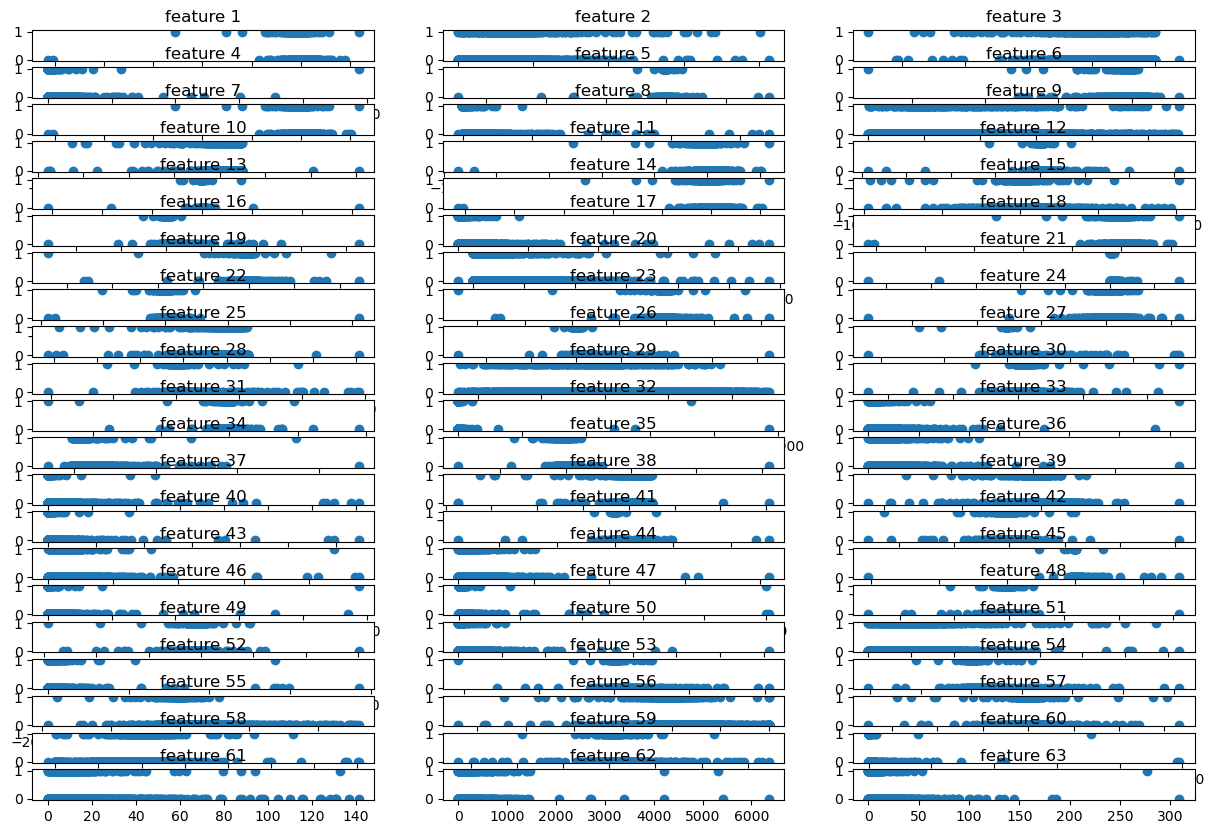

In [16]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(21, 3, figsize=(15, 10))
for i, ax in enumerate(axs.flat):
    xx = X.iloc[:,i]
    mean_y = np.mean(xx)
    std_y = np.std(xx)
    threshold_u = mean_y + 3 * std_y
    threshold_d = mean_y - 3 * std_y
    x_filtered = xx.loc[(xx >=threshold_d)&(xx <=threshold_u)]
    y_filtered = y.loc[(xx >=threshold_d)&(xx <=threshold_u)]
    ax.scatter(x_filtered, y_filtered)
    ax.set_title(f'feature {i+1}')
plt.tight_layout()
plt.show()


## Distribution Diagram

Text(0.5, 1.0, 'feature 1')

Text(0.5, 1.0, 'feature 2')

Text(0.5, 1.0, 'feature 3')

Text(0.5, 1.0, 'feature 4')

Text(0.5, 1.0, 'feature 5')

Text(0.5, 1.0, 'feature 6')

Text(0.5, 1.0, 'feature 7')

Text(0.5, 1.0, 'feature 8')

Text(0.5, 1.0, 'feature 9')

Text(0.5, 1.0, 'feature 10')

Text(0.5, 1.0, 'feature 11')

Text(0.5, 1.0, 'feature 12')

Text(0.5, 1.0, 'feature 13')

Text(0.5, 1.0, 'feature 14')

Text(0.5, 1.0, 'feature 15')

Text(0.5, 1.0, 'feature 16')

Text(0.5, 1.0, 'feature 17')

Text(0.5, 1.0, 'feature 18')

Text(0.5, 1.0, 'feature 19')

Text(0.5, 1.0, 'feature 20')

Text(0.5, 1.0, 'feature 21')

Text(0.5, 1.0, 'feature 22')

Text(0.5, 1.0, 'feature 23')

Text(0.5, 1.0, 'feature 24')

Text(0.5, 1.0, 'feature 25')

Text(0.5, 1.0, 'feature 26')

Text(0.5, 1.0, 'feature 27')

Text(0.5, 1.0, 'feature 28')

Text(0.5, 1.0, 'feature 29')

Text(0.5, 1.0, 'feature 30')

Text(0.5, 1.0, 'feature 31')

Text(0.5, 1.0, 'feature 32')

Text(0.5, 1.0, 'feature 33')

Text(0.5, 1.0, 'feature 34')

Text(0.5, 1.0, 'feature 35')

Text(0.5, 1.0, 'feature 36')

Text(0.5, 1.0, 'feature 37')

Text(0.5, 1.0, 'feature 38')

Text(0.5, 1.0, 'feature 39')

Text(0.5, 1.0, 'feature 40')

Text(0.5, 1.0, 'feature 41')

Text(0.5, 1.0, 'feature 42')

Text(0.5, 1.0, 'feature 43')

Text(0.5, 1.0, 'feature 44')

Text(0.5, 1.0, 'feature 45')

Text(0.5, 1.0, 'feature 46')

Text(0.5, 1.0, 'feature 47')

Text(0.5, 1.0, 'feature 48')

Text(0.5, 1.0, 'feature 49')

Text(0.5, 1.0, 'feature 50')

Text(0.5, 1.0, 'feature 51')

Text(0.5, 1.0, 'feature 52')

Text(0.5, 1.0, 'feature 53')

Text(0.5, 1.0, 'feature 54')

Text(0.5, 1.0, 'feature 55')

Text(0.5, 1.0, 'feature 56')

Text(0.5, 1.0, 'feature 57')

Text(0.5, 1.0, 'feature 58')

Text(0.5, 1.0, 'feature 59')

Text(0.5, 1.0, 'feature 60')

Text(0.5, 1.0, 'feature 61')

Text(0.5, 1.0, 'feature 62')

Text(0.5, 1.0, 'feature 63')

D:\temp\ipykernel_10956\3674182317.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


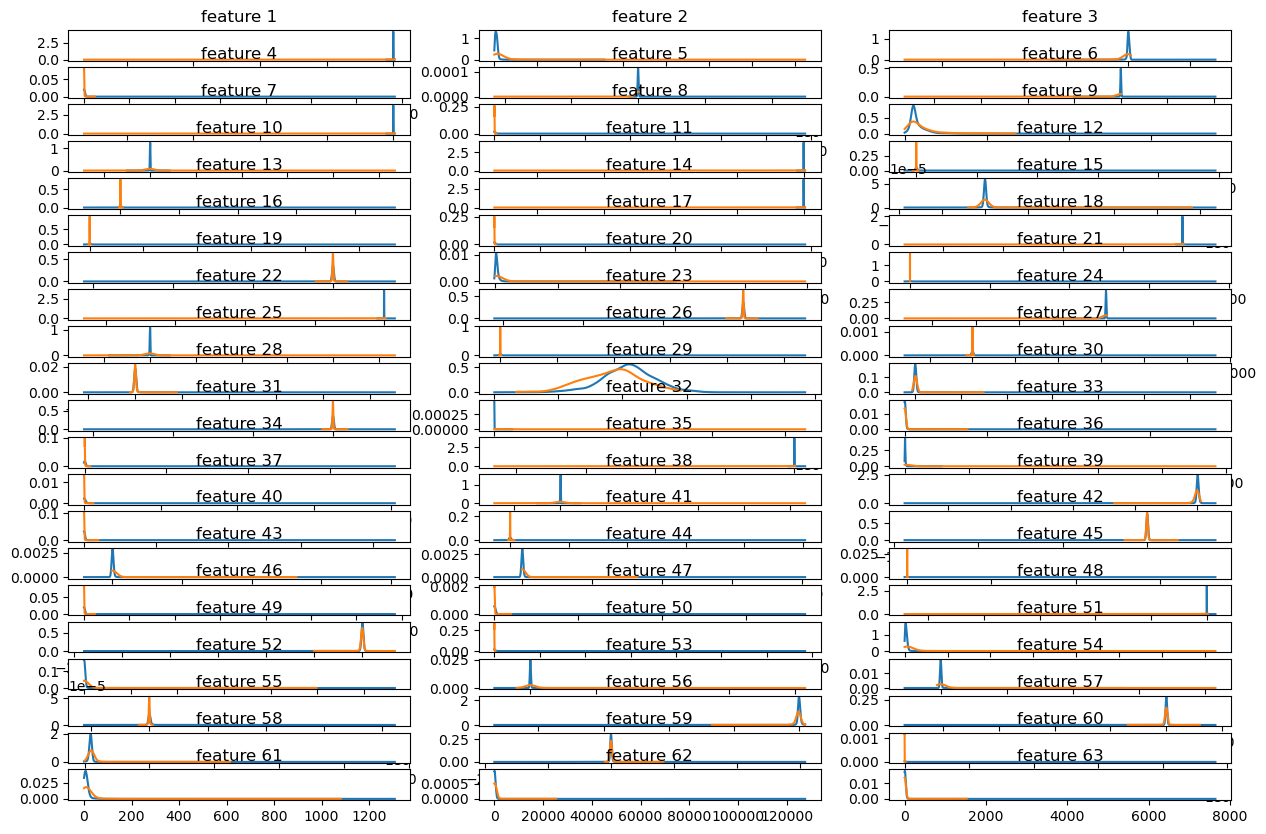

In [17]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
fig, axs = plt.subplots(21, 3, figsize=(15, 10))
def cleaning(X):
    for i in range(64):
        X.iloc[:,i].fillna(np.nanmedian(X.iloc[:,i].values),inplace = True)
    return X
XX = cleaning(X)
for i, ax in enumerate(axs.flat):
    xx = XX.iloc[:,i]
    datas = {'category': y.iloc[:,0].values.tolist(),'B': xx.values.tolist()}
    datass = pd.DataFrame(datas)
    grouped = datass.groupby('category')
    for name, group in grouped:
        kde = gaussian_kde(group['B'])
        xxx = np.linspace(min(group['B']), max(group['B']), 1000)
        yyy = kde(xxx)
        ax.plot(xxx, yyy)
        #ax.hist(group['B'], alpha=0.5, label=f'Category {name}')    
    ax.set_title(f'feature {i+1}')
plt.tight_layout()
plt.show()

**Result**
- According to data imbalance analysis, the amount of bancuptcy is considerably less than the amout of survival.what we shall do is to use loss sensitive training and data augomentation or try to find a model cannot be affected by data imbalanced,such as dicision tree.
- These features are highly correlated with each other and some of them are redundant. Consequently, I should apply unsupervised learning such as PCA to reduce the dimension of data.
- By box plot, It is clear to uncover that there are outliers in each features.
- visualizing all features, for some kinds of features, I discover that the available data comes from one or more groups each with its own distribution.Those features should be transformed and imposed homogeneity

# Recipe step C: Prepare the data

## Recipe C1: Cleaning

In [18]:
def cleaning(X):
    for i in range(64):
        X.iloc[:,i].fillna(np.nanmedian(X.iloc[:,i].values),inplace = True)
    return X


X = cleaning(X)
a= X.isnull().sum().sum()
print("There are {a1} null values in feature matrix".format(a1=a))

imputation = SimpleImputer(strategy='median')# used for pipeline code

There are 0 null values in feature matrix


**use median value to take place of missing value**

## Recipe C2: eliminate outliers

In [19]:
def eliminate_outliers(arr, pct_d, pct_u):
    df = pd.DataFrame(arr) 
    for column in df.columns:
        lower_limit = np.percentile(df[column], pct_d)
        upper_limit = np.percentile(df[column], pct_u)
        df[column][df[column] < lower_limit] = lower_limit
        df[column][df[column] > upper_limit] = upper_limit
    return df.to_numpy()

ouuliers_elimination = FunctionTransformer(eliminate_outliers, kw_args={'pct_d': 5, 'pct_u': 95}) # used for pipeline code

**The values which exceed the range of [5%,95%] would be defined as outlier values, which less than 5% quantile should be transformed into 5% quantile and vice versa.**

## Recipe C3: eliminate ineffective feature

In [17]:
def eliminate_feature(arr):
    df = pd.DataFrame(arr)
    columns_to_drop = [df.columns[28], df.columns[36]]
    df1 = df.drop(columns_to_drop,axis=1)
    return df1.to_numpy()

feature_elimination = FunctionTransformer(eliminate_feature) # used for pipeline code

## Why should I delete feature X29?

Text(0.5, 1.0, 'density distribution: logarithm of total assets ')

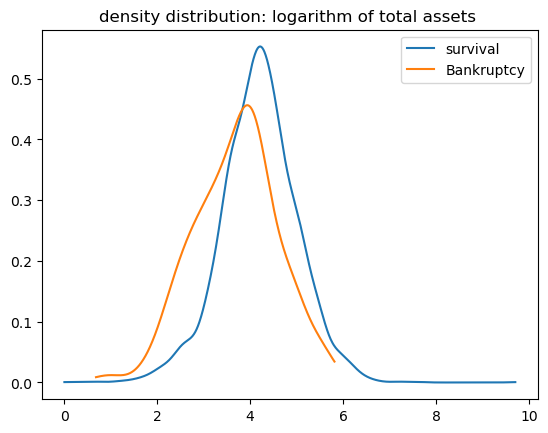

In [21]:
xx = X.iloc[:,28]
datas = {'category': y.iloc[:,0].values.tolist(),'B': xx.values.tolist()}
datass = pd.DataFrame(datas)
grouped = datass.groupby('category')
idd = ["survival",'Bankruptcy']
for name, group in grouped:
    kde = gaussian_kde(group['B'])
    xxx = np.linspace(min(group['B']), max(group['B']), 1000)
    yyy = kde(xxx)
    plt.plot(xxx, yyy,label=idd[name])
    #ax.hist(group['B'], alpha=0.5, label=f'Category {name}')
plt.legend()
plt.title(f'density distribution: logarithm of total assets ')
plt.show()

- **As the figure showed in recipe B4, the X29 is a feature called "logarithm of total assets". The density distribution figures of X29 with defferent groups( bankruptcy and survival) have the same distribution.**

- **Therefore, X29 is ineffective and should be eliminated.**

## Why should I delete feature X37?

**Because X37 lacks of a lot of values.**

## Recipe C4: Standardization

In [22]:
scaler = StandardScaler()

**Principal component analysis(PCA) is extreme sensitive to the scale of data.Thus,standardization process is essential**

## Recipe C5：PCA

PCA()

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Cumulative Variance Explained')

Text(0.5, 0, 'number of components')

Text(0, 0.5, 'Cumulative Variance Explained')

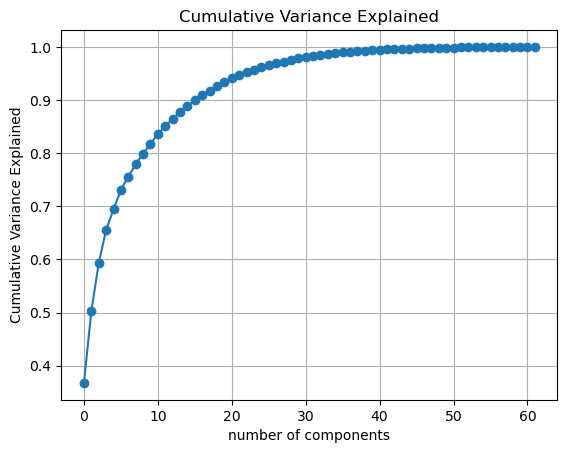

The first22 components contain 95.0% information!


In [23]:
transform_pipeline = Pipeline([
    ("Imputer",imputation),
    ("ouuliers_elimination",ouuliers_elimination),
    ("feature_elimination",feature_elimination),
    ("scaler",scaler)])
X_transfer = transform_pipeline.fit_transform(X)

pca0 = PCA(n_components = None)
pca0.fit(X_transfer)
explained_variance_ratio = pca0.explained_variance_ratio_
cummulative_variance = np.cumsum(pca0.explained_variance_ratio_)
plt.figure()
plt.plot(cummulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Variance Explained')
plt.xlabel('number of components')
plt.ylabel('Cumulative Variance Explained')
plt.grid()
plt.show()

information_ = 0.95
zz = 62-cummulative_variance[cummulative_variance >= information_].size
print("The first{z1} components contain {z2}% information!".format(z1=zz,z2 =information_*100 ))

pca = PCA(n_components = zz)#used for pipeline

**By PCA model, reduce the dimension of data. The first 22 components contain 95% information.I reproduce a new PCA model with parameter(n_components = 22) used for  classification model training**

# Recipe step D: Train a model

## Recipe D1: Native Bay model (fit, cross validation, error analysis)

###         Fit and Crossvalidation

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('Imputer', SimpleImputer(strategy='median')),
                ('ouuliers_elimination',
                 FunctionTransformer(func=<function eliminate_outliers at 0x000001DAE4EABCE0>,
                                     kw_args={'pct_d': 5, 'pct_u': 95})),
                ('feature_elimination',
                 FunctionTransformer(func=<function eliminate_feature at 0x000001DAD614B060>)),
                ('scaler', StandardScaler()), ('PCA', PCA(n_components=22)),
                ('native_bay', GaussianNB())])

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: Native_Bay In-sample Accuracy=88.5%



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Model: Native_Bay avg cross validation accuracy=0.88

Model: Native_Bay avg cross validation precision=0.24

Model: Native_Bay avg cross validation recall=0.44



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted labels')

Text(70.72222222222221, 0.5, 'Actual labels')

Text(0.5, 1.0, 'Confusion Matrix')

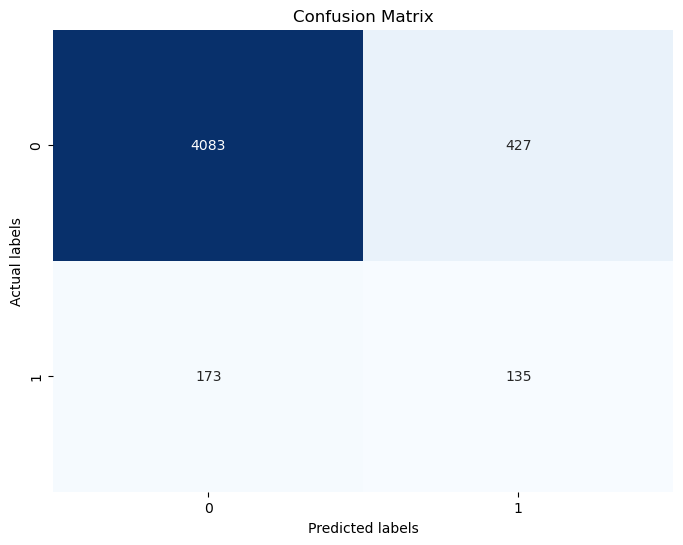

In [24]:
from sklearn.naive_bayes import GaussianNB
# import model
native_bay = GaussianNB()
# create pipeline
random_forest_pipeline = Pipeline([
    ("Imputer",imputation),
    ("ouuliers_elimination",ouuliers_elimination),
    ("feature_elimination",feature_elimination),
    ("scaler",scaler),
    ("PCA",pca),
    ("native_bay",native_bay)])

# fit model
random_forest_pipeline.fit(X,y)

# the accuracy of set in sample
y_predict = random_forest_pipeline.predict(X)
accuracy_train = accuracy_score(y, y_predict)
name = "Native_Bay"                                                                    #change
print("Model: {m:s} In-sample Accuracy={s:3.1%}\n".format(m=name, s=accuracy_train))

# cross validation confusion matrix
# cross validation
from sklearn.model_selection import train_test_split, cross_val_score
y_pred = cross_val_predict(random_forest_pipeline, X, y, cv=10)
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
print("Model: {m:s} avg cross validation accuracy={s:3.2f}\n".format(m=name, s=accuracy ))
print("Model: {m:s} avg cross validation precision={s:3.2f}\n".format(m=name, s=precision ))
print("Model: {m:s} avg cross validation recall={s:3.2f}\n".format(m=name, s=recall ))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title('Confusion Matrix')
plt.show()


### Change Threshold

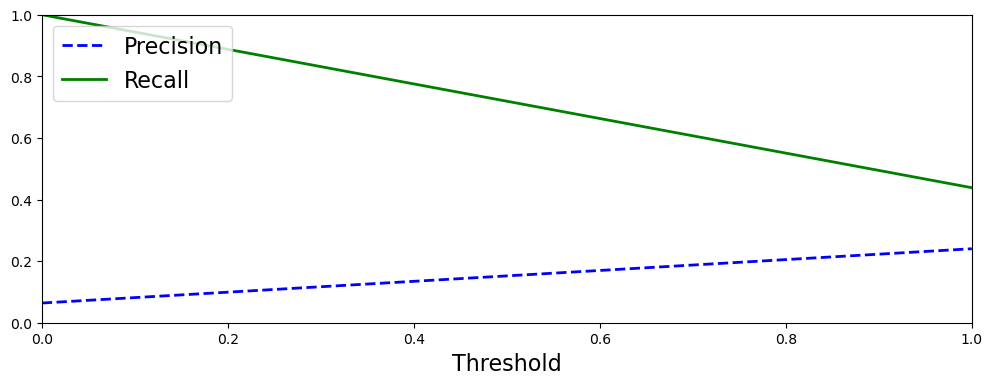

The F1 score of Native_Bay model is 0.3103448275862069


In [26]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y, y_pred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, probs=None):
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    horiz = thresholds
    label = "Threshold"
    _ = ax.plot(horiz, precisions[:-1], "b--", label="Precision", linewidth=2)
    _ = ax.plot(horiz, recalls[:-1], "g-", label="Recall", linewidth=2)
    _ = ax.set_xlabel(label, fontsize=16)
    _ = ax.legend(loc="upper left", fontsize=16)
    _ = ax.set_ylim([0, 1])
    _ = ax.set_xlim([ horiz.min(), horiz.max()])
    return fig, ax
fig, ax = plot_precision_recall_vs_threshold(precisions, recalls, thresholds)#, probs=probs)
plt.close(fig)
fig
from sklearn.metrics import f1_score
f1 = f1_score(y, y_pred)
print("The F1 score of {a1} model is {a2}".format(a1= name,a2=f1))

### Error Analysis of Native Model
- **As a Baseline Model, the performance matrix is not great. The unconditional accuracy is 88% lower than 93.5%, which is the accuracy result of predicting all samples as 0.**
- **The conditional accuracy results including recall and precision are 44% and 24% separately. The preformance of recall is better than I think,but the precision is much low and the f1 score is 0.3 far from 1(the closer to 1 the f1, the better traderoff between recall and precision).**
- **Therefore,Native Bay model cannot be a good choice of predicting bankruptcy.**

## Recipe D2: Random forest model (fit, cross validation, error analysis)

### Fit random forest model

In [27]:
# import model
class_weights = {0:1, 1: 20}
random_forest = RandomForestClassifier(n_estimators=100,max_depth=5, random_state=42, class_weight=class_weights)# change
# create pipeline
random_forest_pipeline = Pipeline([
    ("Imputer",imputation),
    ("ouuliers_elimination",ouuliers_elimination),
    ("feature_elimination",feature_elimination),
    ("scaler",scaler),
    ("PCA",pca),
    ("random_forest",random_forest)])

# fit model
random_forest_pipeline.fit(X,y)

# the accuracy of set in sample
y_predict = random_forest_pipeline.predict(X)
accuracy_train = accuracy_score(y, y_predict)
name = "random forest"                                                                    #change
print("Model: {m:s} In-sample Accuracy={s:3.1%}\n".format(m=name, s=accuracy_train))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('Imputer', SimpleImputer(strategy='median')),
                ('ouuliers_elimination',
                 FunctionTransformer(func=<function eliminate_outliers at 0x000001DAE4EABCE0>,
                                     kw_args={'pct_d': 5, 'pct_u': 95})),
                ('feature_elimination',
                 FunctionTransformer(func=<function eliminate_feature at 0x000001DAD614B060>)),
                ('scaler', StandardScaler()), ('PCA', PCA(n_components=22)),
                ('random_forest',
                 RandomForestClassifier(class_weight={0: 1, 1: 20}, max_depth=5,
                                        random_state=42))])

Model: random forest In-sample Accuracy=86.6%



### Cross validation

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

Model: random forest avg cross validation accuracy=0.85

Model: random forest avg cross validation precision=0.24

Model: random forest avg cross validation recall=0.61



<Figure size 800x600 with 0 Axes>

<Axes: >

Text(70.72222222222221, 0.5, 'Actual labels')

Text(0.5, 36.72222222222221, 'Predicted labels')

Text(0.5, 1.0, 'Confusion Matrix')

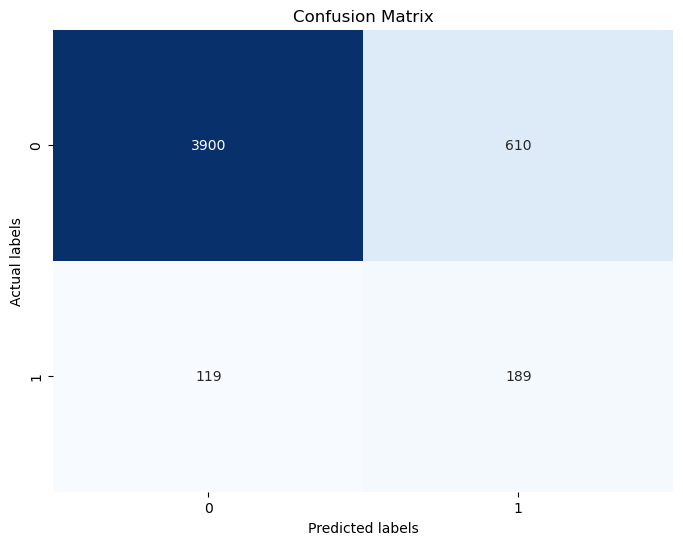

In [28]:
# cross validation confusion matrix
# cross validation
from sklearn.model_selection import train_test_split, cross_val_score
y_pred = cross_val_predict(random_forest_pipeline, X, y, cv=10)
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
print("Model: {m:s} avg cross validation accuracy={s:3.2f}\n".format(m=name, s=accuracy ))
print("Model: {m:s} avg cross validation precision={s:3.2f}\n".format(m=name, s=precision ))
print("Model: {m:s} avg cross validation recall={s:3.2f}\n".format(m=name, s=recall ))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.title('Confusion Matrix')
plt.show()

### change threshold

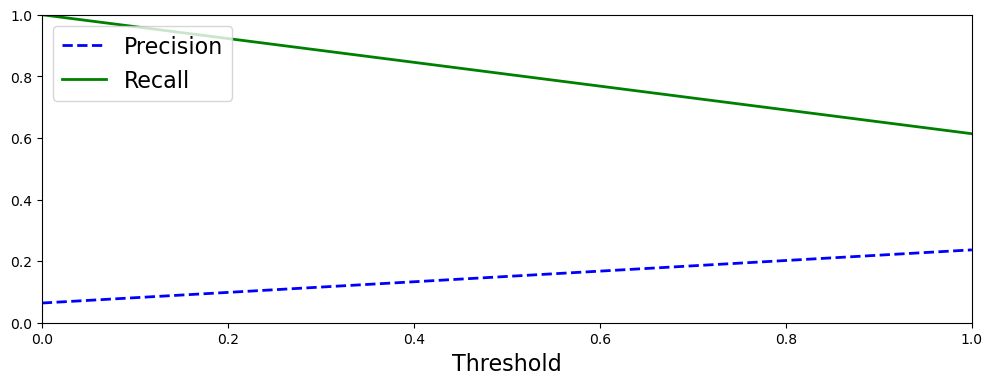

The F1 score of random forest model is 0.34146341463414637


In [30]:
precisions, recalls, thresholds = precision_recall_curve(y, y_pred)
fig, ax = plot_precision_recall_vs_threshold(precisions, recalls, thresholds)#, probs=probs)
plt.close(fig)
fig
f1 = f1_score(y, y_pred)
print("The F1 score of {a1} model is {a2}".format(a1= name,a2=f1))

### ROC Curve and AUC 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('Imputer', SimpleImputer(strategy='median')),
                ('ouuliers_elimination',
                 FunctionTransformer(func=<function eliminate_outliers at 0x000001DAE4EABCE0>,
                                     kw_args={'pct_d': 5, 'pct_u': 95})),
                ('feature_elimination',
                 FunctionTransformer(func=<function eliminate_feature at 0x000001DAD614B060>)),
                ('scaler', StandardScaler()), ('PCA', PCA(n_components=22)),
                ('random_forest',
                 RandomForestClassifier(class_weight={0: 1, 1: 20}, max_depth=5,
                                        random_state=42))])

<Figure size 800x600 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic')

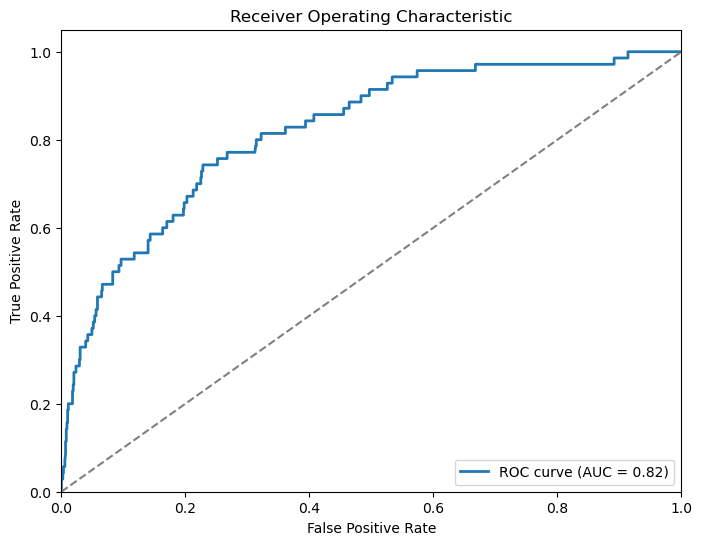

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
random_forest_pipeline.fit(X_train, y_train)
y_prob = random_forest_pipeline.predict_proba(X_test)[:, 1]
# ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Error Analysis
- **The result of random forest is better than Native Bay Model.The unconditional accuracy score is 86.6%, which looks like a worse result. However, the unconditional accuracy is decreased by myself in order to improve recall score.**
- **The conditional accuracy results including recall and precision are 61% and 24% separately. The reccall score has been improved from 44% to 61%.**
- **AUC is termed as the area under curve,which  is a indicator showing how well the model trades off recall and precision scores and the AUC of random forest is 0.82.**
- **In total, random forest is a useful model to predict bankruptcy.**

## Recipe D3: Logistic regression model (fit, cross validation, error analysis)

### Fit and Cross validation

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('Imputer', SimpleImputer(strategy='median')),
                ('ouuliers_elimination',
                 FunctionTransformer(func=<function eliminate_outliers at 0x000001DAE4EABCE0>,
                                     kw_args={'pct_d': 5, 'pct_u': 95})),
                ('feature_elimination',
                 FunctionTransformer(func=<function eliminate_feature at 0x000001DAD614B060>)),
                ('scaler', StandardScaler()),
                ('random_forest', LogisticRegression())])

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: Logistic_Regression In-sample Accuracy=94.8%



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (

Model: Logistic_Regression avg cross validation accuracy=0.94

Model: Logistic_Regression avg cross validation precision=0.60

Model: Logistic_Regression avg cross validation recall=0.24



<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted labels')

Text(70.72222222222221, 0.5, 'Actual labels')

Text(0.5, 1.0, 'Confusion Matrix')

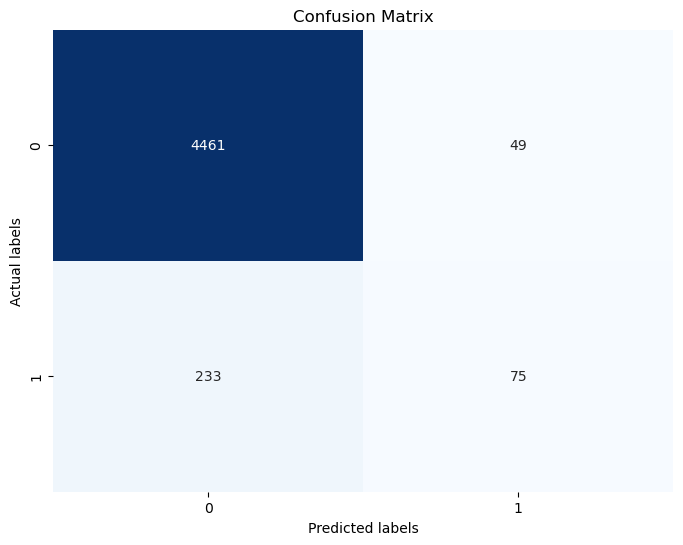

In [32]:
# import model
from sklearn.linear_model import LogisticRegression
Logistic_Regression = LogisticRegression()# change
# create pipeline
random_forest_pipeline = Pipeline([
    ("Imputer",imputation),
    ("ouuliers_elimination",ouuliers_elimination),
    ("feature_elimination",feature_elimination),
    ("scaler",scaler),
    ("random_forest",Logistic_Regression)])         #change

# fit model
random_forest_pipeline.fit(X,y)

# the accuracy of set in sample
y_predict = random_forest_pipeline.predict(X)
accuracy_train = accuracy_score(y, y_predict)
name = "Logistic_Regression"                                                                    #change
print("Model: {m:s} In-sample Accuracy={s:3.1%}\n".format(m=name, s=accuracy_train))

# cross validation confusion matrix
# cross validation
from sklearn.model_selection import train_test_split, cross_val_score
y_pred = cross_val_predict(random_forest_pipeline, X, y, cv=10)
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
print("Model: {m:s} avg cross validation accuracy={s:3.2f}\n".format(m=name, s=accuracy ))
print("Model: {m:s} avg cross validation precision={s:3.2f}\n".format(m=name, s=precision ))
print("Model: {m:s} avg cross validation recall={s:3.2f}\n".format(m=name, s=recall ))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title('Confusion Matrix')
plt.show()

### change Threshold

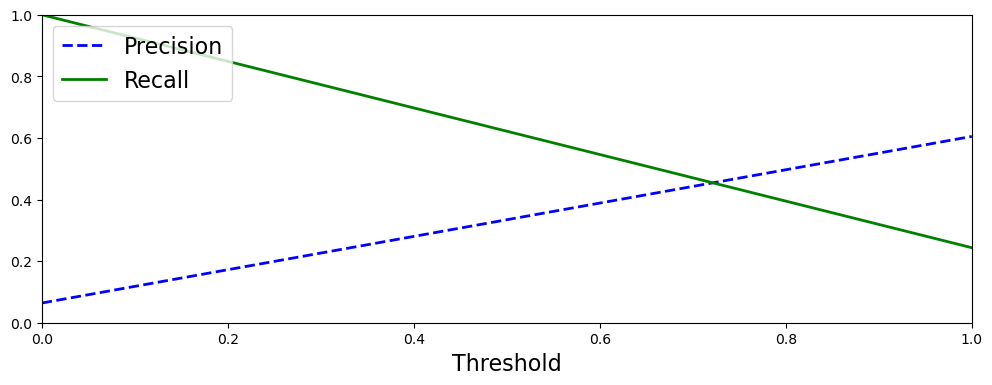

The F1 score of Logistic_Regression model is 0.3472222222222222


In [34]:
precisions, recalls, thresholds = precision_recall_curve(y, y_pred)
fig, ax = plot_precision_recall_vs_threshold(precisions, recalls, thresholds)#, probs=probs)
plt.close(fig)
fig
f1 = f1_score(y, y_pred)
print("The F1 score of {a1} model is {a2}".format(a1= name,a2=f1))

### Error Analysis
- **The result of logistic regression is worse than Native Bay Model.The unconditional accuracy score is 94%.**
- **The conditional accuracy results including recall and precision are 24% and 60% separately. The recall is too low to predict the companies would bankrupt.**
- **In total, Logistic regression is not a effective model,because it cannot solve the problem of data imbalanced by changing loss function weight.**

## Recipe D4: Support Vector Machine (fit, cross validation, error analysis)

### Fit and Cross Validation

{'random_forest__C': 1,
 'random_forest__class_weight': 'balanced',
 'random_forest__gamma': 0.001,
 'random_forest__kernel': 'rbf'}

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('Imputer', SimpleImputer(strategy='median')),
                ('ouuliers_elimination',
                 FunctionTransformer(func=<function eliminate_outliers at 0x000001DAE4EABCE0>,
                                     kw_args={'pct_d': 5, 'pct_u': 95})),
                ('feature_elimination',
                 FunctionTransformer(func=<function eliminate_feature at 0x000001DAD614B060>)),
                ('scaler', StandardScaler()),
                ('random_forest',
                 SVC(C=10, class_weight={0: 1, 1: 10}, gamma=0.001,
                     probability=True, random_state=42))])

Model: Support_Vector_Machine In-sample Accuracy=90.0%



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Model: Support_Vector_Machine avg cross validation accuracy=0.88

Model: Support_Vector_Machine avg cross validation precision=0.29

Model: Support_Vector_Machine avg cross validation recall=0.62



<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted labels')

Text(70.72222222222221, 0.5, 'Actual labels')

Text(0.5, 1.0, 'Confusion Matrix')

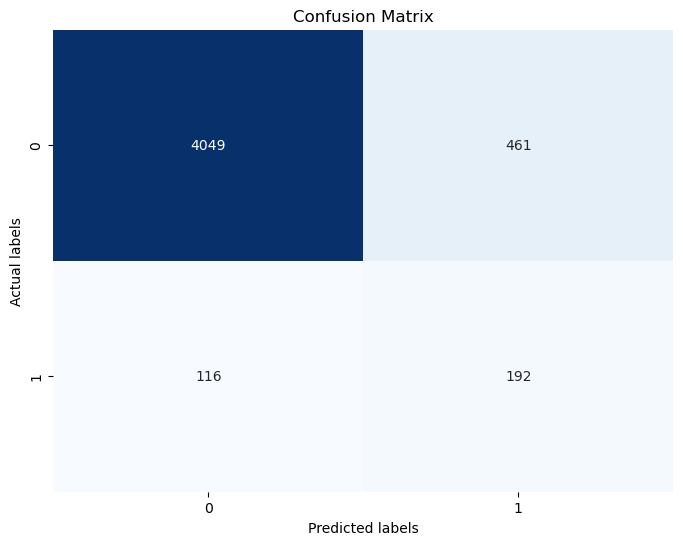

In [35]:
# import model
from sklearn.svm import SVC
class_weights = {0:1, 1: 10}
{'random_forest__C': 1, 'random_forest__class_weight': 'balanced', 'random_forest__gamma': 0.001, 'random_forest__kernel': 'rbf'}
SVC3 = SVC(C = 10,gamma = 0.001,kernel='rbf', random_state=42,class_weight =class_weights,probability=True)# change
# create pipeline
random_forest_pipeline = Pipeline([
    ("Imputer",imputation),
    ("ouuliers_elimination",ouuliers_elimination),
    ("feature_elimination",feature_elimination),
    ("scaler",scaler),
    ("random_forest",SVC3)])                                       #change

# fit model
random_forest_pipeline.fit(X,y)

# the accuracy of set in sample
y_predict = random_forest_pipeline.predict(X)
accuracy_train = accuracy_score(y, y_predict)
name = "Support_Vector_Machine"                                                                    #change
print("Model: {m:s} In-sample Accuracy={s:3.1%}\n".format(m=name, s=accuracy_train))

# cross validation confusion matrix
# cross validation
from sklearn.model_selection import train_test_split, cross_val_score
y_pred = cross_val_predict(random_forest_pipeline, X, y, cv=10)
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
print("Model: {m:s} avg cross validation accuracy={s:3.2f}\n".format(m=name, s=accuracy ))
print("Model: {m:s} avg cross validation precision={s:3.2f}\n".format(m=name, s=precision ))
print("Model: {m:s} avg cross validation recall={s:3.2f}\n".format(m=name, s=recall ))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title('Confusion Matrix')
plt.show()

### ROC Curve and AUC

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('Imputer', SimpleImputer(strategy='median')),
                ('ouuliers_elimination',
                 FunctionTransformer(func=<function eliminate_outliers at 0x000001DAE4EABCE0>,
                                     kw_args={'pct_d': 5, 'pct_u': 95})),
                ('feature_elimination',
                 FunctionTransformer(func=<function eliminate_feature at 0x000001DAD614B060>)),
                ('scaler', StandardScaler()),
                ('random_forest',
                 SVC(C=10, class_weight={0: 1, 1: 10}, gamma=0.001,
                     probability=True, random_state=42))])

<Figure size 800x600 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic')

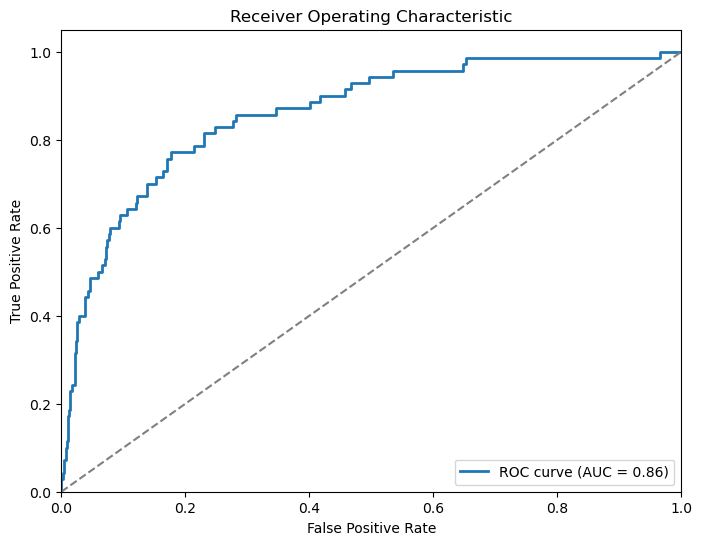

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
random_forest_pipeline.fit(X_train, y_train)
y_prob = random_forest_pipeline.predict_proba(X_test)[:, 1]
# ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Change threshold

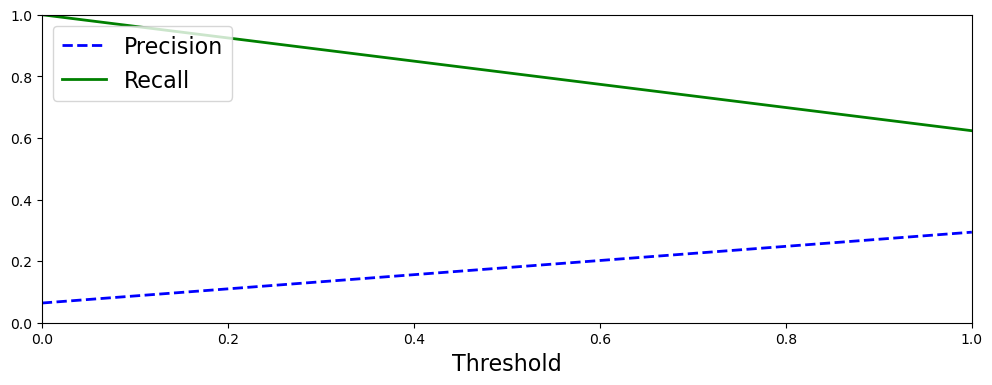

The F1 score of Support_Vector_Machine model is 0.3995837669094693


In [37]:
precisions, recalls, thresholds = precision_recall_curve(y, y_pred)
fig, ax = plot_precision_recall_vs_threshold(precisions, recalls, thresholds)#, probs=probs)
plt.close(fig)
fig
f1 = f1_score(y, y_pred)
print("The F1 score of {a1} model is {a2}".format(a1= name,a2=f1))

### Error Analysis
- **The result of Support Vector model is even slightly better than random forest Model.The unconditional accuracy score is 88%**
- **The conditional accuracy results including recall and precision are 62% and 29% separately. The reccall score has been improved from 61% to 62%.It sounds unlike a big deal,but the precision score 29% larger than the precision(21%) of random forest.**
- **AUC is termed as the area under curve,which  is a indicator showing how well the model trades off recall and precision scores and the AUC of random forest is 0.86.**
- **In total, Support Vector machine is also a useful model to predict bankruptcy.**

## Recipe D5: Result

- **In summary, There are two classification modle,Random Forest and Support Vector Machine, available for bankrupt classification task.**
- **In this case, compared to normal firms predicted as bankrupt companies, the mistaken prediction of bankrupt companies predicted as normal firms would results in a more serious consequence;that is,the recall score is more important than precision score.The reason is if  a bank lends a lot of fund to companies are going bankrupt,it would bear considerable loss.On the contrary, even if a normal company is mistakenly predicted as bankrupt firm, The bank still has a lot of chances to invest other companies.**
- **The data imbalanced problem should be solved by changing each group weight of loss function.Random forest and SVC have a common parameter,class_wight,used to control the weight of each group.**
- **What should we do is to make recall score as large as possible and keep accuracy at a high level.Otherwise, the bank lacks of enough companies worth investing in.**


# Recipe step E: Fine tune

## Recipe E1: Introduce

- **In order to achieve the goal of making recall score as large as possible and keeping accuracy at a high level, I construct a objective function   ( score = 0.7*accuracy+0.3*recall ) as scoring parameter of gridsearch model.**
- **Apply gridsearch method for SVM and random forest,choose the model and parameters with the higest socre as final one used to predict bankcuptcy.**

## Recipe E2: Hype parameter tuning (random forest)

### Grid_Search

In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# parameter
'''
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly'],
    'class_weight': [ 'balanced', {0: 1, 1: 20},{0: 1, 1: 25}]
}


'''
param_grid = {
    'random_forest__n_estimators': [100,150, 200],
    'random_forest__max_depth': [5,7 , 10],
    'random_forest__class_weight': [ 'balanced', {0: 1, 1: 20},{0: 1, 1: 25}]
}

'''
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
'''
# random forest
model1 = RandomForestClassifier(random_state=42)
random_forest_pipeline = Pipeline([
    ("Imputer",imputation),
    ("ouuliers_elimination",ouuliers_elimination),
    ("feature_elimination",feature_elimination),
    ("scaler",scaler),
    ("PCA",pca),
    ("random_forest",model1)])

from sklearn.metrics import make_scorer, f1_score

#  score funcion
def custom_scorer(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    final = 0.75*accuracy+0.25*recall
    # 
    return final

# grid search
grid_search = GridSearchCV(random_forest_pipeline, param_grid, cv=2, scoring=make_scorer(custom_scorer))



#grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# test accuracy
best_model = grid_search.best_estimator_
y_pred1 = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred1)
print("Test Accuracy:", accuracy)


"\nparam_grid = {\n    'C': [0.1, 1, 10],\n    'gamma': [0.1, 0.01, 0.001],\n    'kernel': ['rbf', 'linear', 'poly'],\n    'class_weight': [ 'balanced', {0: 1, 1: 20},{0: 1, 1: 25}]\n}\n\n\n"

"\nparam_grid = {\n    'n_estimators': [100, 200, 300],\n    'max_depth': [None, 5, 10, 20],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4]\n}\n"

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('Imputer',
                                        SimpleImputer(strategy='median')),
                                       ('ouuliers_elimination',
                                        FunctionTransformer(func=<function eliminate_outliers at 0x000001DAE4EABCE0>,
                                                            kw_args={'pct_d': 5,
                                                                     'pct_u': 95})),
                                       ('feature_elimination',
                                        FunctionTransformer(func=<function eliminate_feature at 0x000001DAD614B060>)),
                                       ('scaler', StandardScaler()),
                                       ('PCA', PCA(n_components=22)),
                                       ('random_forest',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'random_forest__class_weight': ['balanced',
                                                         {0: 1, 1: 20},
                                                         {0: 1, 1: 25}],
                         'random_forest__max_depth': [5, 7, 10],
                         'random_forest__n_estimators': [100, 150, 200]},
             scoring=make_scorer(custom_scorer))

Best Parameters: {'random_forest__class_weight': {0: 1, 1: 20}, 'random_forest__max_depth': 5, 'random_forest__n_estimators': 100}
Best Score: 0.7998832381940841
Test Accuracy: 0.8506224066390041


### The best result of random forest

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('Imputer', SimpleImputer(strategy='median')),
                ('ouuliers_elimination',
                 FunctionTransformer(func=<function eliminate_outliers at 0x000001DAE4EABCE0>,
                                     kw_args={'pct_d': 5, 'pct_u': 95})),
                ('feature_elimination',
                 FunctionTransformer(func=<function eliminate_feature at 0x000001DAD614B060>)),
                ('scaler', StandardScaler()), ('PCA', PCA(n_components=22)),
                ('random_forest',
                 RandomForestClassifier(class_weight={0: 1, 1: 20}, max_depth=5,
                                        random_state=42))])

Model: random forest In-sample Accuracy=86.6%



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

Model: random forest avg cross validation accuracy=0.85

Model: random forest avg cross validation precision=0.24

Model: random forest avg cross validation recall=0.62



<Figure size 800x600 with 0 Axes>

<Axes: >

Text(70.72222222222221, 0.5, 'Actual labels')

Text(0.5, 36.72222222222221, 'Predicted labels')

Text(0.5, 1.0, 'Confusion Matrix')

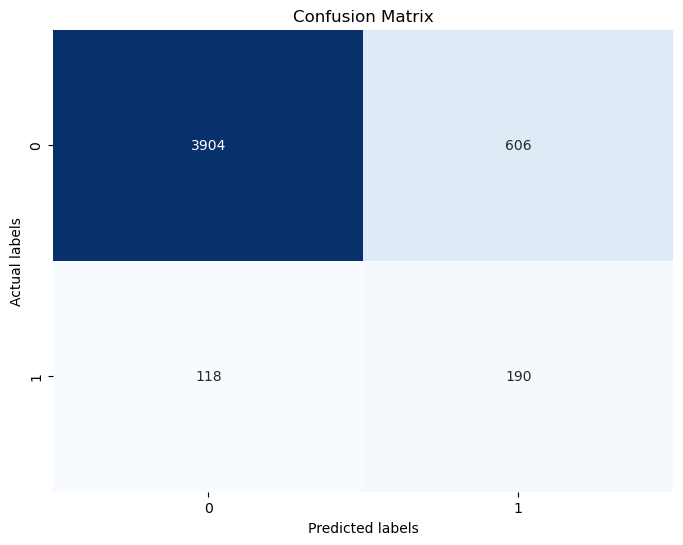

In [39]:
class_weights = {0:1, 1: 20}
random_forest = RandomForestClassifier(n_estimators=100,max_depth=5, random_state=42, class_weight=class_weights)# change
# create pipeline
random_forest_pipeline = Pipeline([
    ("Imputer",imputation),
    ("ouuliers_elimination",ouuliers_elimination),
    ("feature_elimination",feature_elimination),
    ("scaler",scaler),
    ("PCA",pca),
    ("random_forest",random_forest)])
random_forest_pipeline.fit(X,y)
y_predict = random_forest_pipeline.predict(X)
accuracy_train = accuracy_score(y, y_predict)
name = "random forest"                                                                    #change
print("Model: {m:s} In-sample Accuracy={s:3.1%}\n".format(m=name, s=accuracy_train))
y_pred = cross_val_predict(random_forest_pipeline, X, y, cv=10)
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
print("Model: {m:s} avg cross validation accuracy={s:3.2f}\n".format(m=name, s=accuracy ))
print("Model: {m:s} avg cross validation precision={s:3.2f}\n".format(m=name, s=precision ))
print("Model: {m:s} avg cross validation recall={s:3.2f}\n".format(m=name, s=recall ))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.title('Confusion Matrix')
plt.show()

- random forest avg cross validation accuracy=0.85

- random forest avg cross validation precision=0.23

- random forest avg cross validation recall=0.61

### Recipe E3: Hype parameter tuning (SVM)

### Grid_Search

In [40]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# split X,y into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# parameter
param_grid = {
    'random_forest__C': [0.1, 1, 10],
    'random_forest__gamma': [0.0001, 0.01, 0.001],
    'random_forest__kernel': ['rbf', 'linear', 'poly'],
    'random_forest__class_weight': [ 'balanced', {0: 1, 1: 10},{0: 1, 1: 5}]
}


'''
param_grid = {
    'n_estimators': [100,150, 200],
    'max_depth': [None, 5, 10],
    'class_weight': [ 'balanced', {0: 1, 1: 2},{0: 1, 1: 5},{0: 1, 1: 7},{0: 1, 1: 10}]
}


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
'''
# SVC pipeline
model1 = SVC(random_state=42)
random_forest_pipeline = Pipeline([
    ("Imputer",imputation),
    ("ouuliers_elimination",ouuliers_elimination),
    ("feature_elimination",feature_elimination),
    ("scaler",scaler),
    ("PCA",pca),
    ("random_forest",model1)])

from sklearn.metrics import make_scorer, f1_score

# score function
def custom_scorer(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    final = 0.75*accuracy+0.25*recall
    return final

# grid search
grid_search = GridSearchCV(random_forest_pipeline, param_grid, cv=2, scoring=make_scorer(custom_scorer))



#grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# test
best_model = grid_search.best_estimator_
y_pred1 = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred1)
print("Test Accuracy:", accuracy)

"\nparam_grid = {\n    'n_estimators': [100,150, 200],\n    'max_depth': [None, 5, 10],\n    'class_weight': [ 'balanced', {0: 1, 1: 2},{0: 1, 1: 5},{0: 1, 1: 7},{0: 1, 1: 10}]\n}\n\n\nparam_grid = {\n    'n_estimators': [100, 200, 300],\n    'max_depth': [None, 5, 10, 20],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4]\n}\n"

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('Imputer',
                                        SimpleImputer(strategy='median')),
                                       ('ouuliers_elimination',
                                        FunctionTransformer(func=<function eliminate_outliers at 0x000001DAE4EABCE0>,
                                                            kw_args={'pct_d': 5,
                                                                     'pct_u': 95})),
                                       ('feature_elimination',
                                        FunctionTransformer(func=<function eliminate_feature at 0x000001DAD614B060>)),
                                       ('scaler', StandardScaler()),
                                       ('PCA', PCA(n_components=22)),
                                       ('random_forest',
                                        SVC(random_state=42))]),
             param_grid={'random_forest__C': [0.1, 1, 10],
                         'random_forest__class_weight': ['balanced',
                                                         {0: 1, 1: 10},
                                                         {0: 1, 1: 5}],
                         'random_forest__gamma': [0.0001, 0.01, 0.001],
                         'random_forest__kernel': ['rbf', 'linear', 'poly']},
             scoring=make_scorer(custom_scorer))

Best Parameters: {'random_forest__C': 10, 'random_forest__class_weight': {0: 1, 1: 10}, 'random_forest__gamma': 0.001, 'random_forest__kernel': 'rbf'}
Best Score: 0.8127935398342003
Test Accuracy: 0.8734439834024896


### The best result of SVM

{'random_forest__C': 1,
 'random_forest__class_weight': 'balanced',
 'random_forest__gamma': 0.001,
 'random_forest__kernel': 'rbf'}

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('Imputer', SimpleImputer(strategy='median')),
                ('ouuliers_elimination',
                 FunctionTransformer(func=<function eliminate_outliers at 0x000001DAE4EABCE0>,
                                     kw_args={'pct_d': 5, 'pct_u': 95})),
                ('feature_elimination',
                 FunctionTransformer(func=<function eliminate_feature at 0x000001DAD614B060>)),
                ('scaler', StandardScaler()),
                ('random_forest',
                 SVC(C=10, class_weight={0: 1, 1: 10}, gamma=0.001,
                     probability=True, random_state=42))])

Model: Support_Vector_Machine In-sample Accuracy=90.0%



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Model: Support_Vector_Machine avg cross validation accuracy=0.88

Model: Support_Vector_Machine avg cross validation precision=0.29

Model: Support_Vector_Machine avg cross validation recall=0.62



<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted labels')

Text(70.72222222222221, 0.5, 'Actual labels')

Text(0.5, 1.0, 'Confusion Matrix')

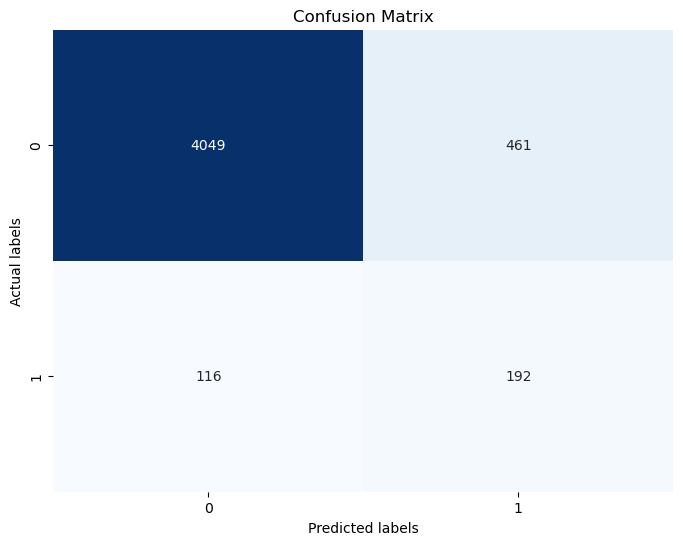

In [41]:
class_weights = {0:1, 1: 10}
{'random_forest__C': 1, 'random_forest__class_weight': 'balanced', 'random_forest__gamma': 0.001, 'random_forest__kernel': 'rbf'}
SVC2 = SVC(C = 10,gamma = 0.001,kernel='rbf', random_state=42,class_weight =class_weights,probability=True)# change
# create pipeline
random_forest_pipeline = Pipeline([
    ("Imputer",imputation),
    ("ouuliers_elimination",ouuliers_elimination),
    ("feature_elimination",feature_elimination),
    ("scaler",scaler),
    ("random_forest",SVC2)])                                       #change

# fit model
random_forest_pipeline.fit(X,y)

# the accuracy of set in sample
y_predict = random_forest_pipeline.predict(X)
accuracy_train = accuracy_score(y, y_predict)
name = "Support_Vector_Machine"                                                                    #change
print("Model: {m:s} In-sample Accuracy={s:3.1%}\n".format(m=name, s=accuracy_train))

# cross validation confusion matrix
# cross validation
from sklearn.model_selection import train_test_split, cross_val_score
y_pred = cross_val_predict(random_forest_pipeline, X, y, cv=10)
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
print("Model: {m:s} avg cross validation accuracy={s:3.2f}\n".format(m=name, s=accuracy ))
print("Model: {m:s} avg cross validation precision={s:3.2f}\n".format(m=name, s=precision ))
print("Model: {m:s} avg cross validation recall={s:3.2f}\n".format(m=name, s=recall ))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title('Confusion Matrix')
plt.show()

- Support_Vector_Machine avg cross validation accuracy=0.88

- Support_Vector_Machine avg cross validation precision=0.29

- Support_Vector_Machine avg cross validation recall=0.6

# Recipe step F: Conclusion

**The SVC model with parameter
({'C': 10, 'class_weight': {0: 1, 1: 10}, 'gamma': 0.001, 'kernel': 'rbf'}) should be indicated as final model.**

# ------------------------------------------End--------------------------------------------

## Submission guidelines

Although your notebook may contain many models (e.g., due to your iterative development)
we will only evaluate a single model.
So choose one (explain why !) and do the following.

- You will implement the body of a subroutine `MyModel`
    - That takes as argument a Pandas DataFrame 
        - Each row is an example on which to predict
        - The features of the example are elements of the row
    - Performs predictions on each example
    - Returns an array or predictions with a one-to-one correspondence with the examples in the test set
    

We will evaluate your model against the holdout data
- By reading the holdout examples `X_hold` (as above)
- Calling `y_hold_pred = MyModel(X_hold)` to get the predictions
- Comparing the predicted values `y_hold_pred` against the true labels `y_hold` which are known only to the instructors

See the following cell as an illustration

**Remember**

The holdout data is in the same format as the one we used for training
- Except that it has no attribute for the target
- So you will need to perform all the transformations on the holdout data
    - As you did on the training data
    - Including turning the string representation of numbers into actual numeric data types

All of this work *must* be performed within the body of the `MyModel` routine you will write

We will grade you by comparing the predictions array you create to the answers known to us.

In [28]:

import pandas as pd
import os
import pandas as pd
import numpy as np
import sklearn
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def MyModel(X_test):
    # It should create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    # import data
    DATA_DIR = "./Data"
    if not os.path.isdir(DATA_DIR):
        DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"
    data_file = "5th_yr.csv"
    data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )
    target_attr = "Bankrupt"
    n_samples, n_attrs = data.shape
    
    # transfer object to numeric and split data into X and y
    df = data
    def to_numeric(df):
        columns = df.select_dtypes(include=['object']).columns
        df[columns] = df[columns].apply(pd.to_numeric, errors='coerce')
        return df
    df= to_numeric(df)
    X = df.iloc[:,0:64]
    y = df.iloc[:,[64]]
    
    
    # used for test
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    #X = X_train
    #y = y_train
    
    
    
    
    # pipeline model
    def cleaning(X):
        for i in range(64):
            X.iloc[:,i].fillna(np.nanmedian(X.iloc[:,i].values),inplace = True)
        return X
    X = cleaning(X)
    imputation = SimpleImputer(strategy='median')# used for imputation
    
    def eliminate_outliers(arr, pct_d, pct_u):
        df = pd.DataFrame(arr) 
        for column in df.columns:
            lower_limit = np.percentile(df[column], pct_d)
            upper_limit = np.percentile(df[column], pct_u)
            df[column][df[column] < lower_limit] = lower_limit
            df[column][df[column] > upper_limit] = upper_limit
        return df.to_numpy()
    ouuliers_elimination = FunctionTransformer(eliminate_outliers, kw_args={'pct_d': 5, 'pct_u': 95}) # used for eliminate outliers
    def eliminate_feature(arr):
        df = pd.DataFrame(arr)
        columns_to_drop = [df.columns[28], df.columns[36]]
        df1 = df.drop(columns_to_drop,axis=1)
        return df1.to_numpy()

    feature_elimination = FunctionTransformer(eliminate_feature) # used for eliminate ineffective feature
    scaler = StandardScaler() # used for standardization
    pca = PCA(n_components = 22)#used for PCA
    
    class_weights = {0:1, 1: 10}
    SVC1 = SVC(C = 10,gamma = 0.001,kernel='rbf', random_state=42,class_weight =class_weights,probability=True)# change
    # create pipeline
    random_forest_pipeline = Pipeline([
        ("Imputer",imputation),
        ("ouuliers_elimination",ouuliers_elimination),
        ("feature_elimination",feature_elimination),
        ("scaler",scaler),
        ("random_forest",SVC1)])                                       #change

    # fit model
    random_forest_pipeline.fit(X,y)
    # predict
    X_test1 = X_test.iloc[:,0:64]
    X_test2 = to_numeric(X_test1)
    y_predict = random_forest_pipeline.predict(X_test2)
    predictions = y_predict
    
    
    return predictions



# Check your work: predict and evaluate metrics on *your* test examples

Although only the instructors have the correct labels for the holdout dataset, you may want
to create your own test dataset on which to evaluate your out of sample metrics.

If you choose to do so, you can evaluate your models using the same metrics that the instructors will use.

- Test whether your implementation of `MyModel` works
- See the metrics  your model produces

In [29]:
name = "SVC"
# import data
DATA_DIR = "./Data"
if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"
data_file = "5th_yr.csv"
X_1 = pd.read_csv( os.path.join(DATA_DIR, "holdout", data_file) )
target_attr = "Bankrupt"

X_test= X_1
#y_test = y
y_test_pred = MyModel(X_test)
print(y_test_pred)
'''
accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test,   y_test_pred, pos_label=1, average="binary")

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )
'''

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1 0 ... 0 0 0]


'\naccuracy_test = accuracy_score(y_test, y_test_pred)\nrecall_test = recall_score(y_test, y_test_pred, pos_label=1, average="binary")\nprecision_test = precision_score(y_test,   y_test_pred, pos_label=1, average="binary")\n\nprint("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,\n                                                                            a=accuracy_test,\n                                                                            r=recall_test,\n                                                                            p=precision_test\n                                                                            )\n         )\n'

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
name = "SVC"
y_test_pred = MyModel(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test,   y_test_pred, pos_label=1, average="binary")

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	SVC Accuracy: 89.2%, Recall 74.3%, Precision 37.7%
